In [1]:
import math
import numpy as np
import scipy.stats as st
import random as rand
import matplotlib.pyplot as plt
from RankEst import *

S = [99, 124, 119, 123, 242, 107, 111, 197,  48,   1, 103,  43, 254, 215, 171, 118, 202, 130, 201, 125, 250,
     89,  71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147,  38,  54,  63, 247, 204,  52, 165,
     229, 241, 113, 216,  49,  21, 4, 199,  35, 195,  24, 150,  5, 154,  7, 18, 128, 226, 235, 39, 178, 117,
     9, 131,  44,  26,  27, 110,  90, 160, 82,  59, 214, 179,  41, 227,  47, 132, 83, 209, 0, 237,  32, 252,
     177,  91, 106, 203, 190,  57,  74,  76,  88, 207, 208, 239, 170, 251,  67,  77,  51, 133,  69, 249,  2,
     127,  80,  60, 159, 168, 81, 163,  64, 143, 146, 157,  56, 245, 188, 182, 218,  33,  16, 255, 243, 210, 
     205,  12,  19, 236,  95, 151,  68,  23, 196, 167, 126,  61, 100,  93,  25, 115, 96, 129,  79, 220,  34,
     42, 144, 136,  70, 238, 184,  20, 222,  94,  11, 219, 224,  50,  58,  10,  73,   6,  36,  92, 194, 211,
     172,  98, 145, 149, 228, 121, 231, 200,  55, 109, 141, 213,  78, 169, 108, 86, 244, 234, 101, 122, 174,
     8, 186, 120,  37,  46,  28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72,
     3, 246, 14, 97, 53, 87, 185, 134, 193,  29, 158, 225, 248, 152,  17, 105, 217, 142, 148, 155,  30, 135, 
     233, 206,  85,  40, 223, 140, 161, 137, 13, 191, 230,  66, 104,  65, 153,  45,  15, 176,  84, 187,  22]

invS = [82,   9, 106, 213,  48,  54, 165,  56, 191,  64, 163, 158, 129, 243, 215, 251, 124, 227,  57, 130, 155,
        47, 255, 135,  52, 142,  67,  68, 196, 222, 233, 203, 84, 123, 148, 50, 166, 194, 35, 61, 238, 76, 149,
        11,  66, 250, 195,  78, 8,  46, 161, 102,  40, 217,  36, 178, 118,  91, 162, 73, 109, 139, 209,37, 114,
        248, 246, 100, 134, 104, 152,  22, 212, 164, 92, 204,  93, 101, 182, 146, 108, 112,  72,  80, 253, 237,
        185, 218,  94,  21,  70,  87, 167, 141, 157, 132, 144, 216, 171,   0, 140, 188, 211,  10, 247, 228, 88,
        5, 184, 179,  69,  6, 208,  44,  30, 143, 202,  63, 15,  2, 193, 175, 189, 3, 1, 19, 138, 107, 58, 145,
        17,  65,  79, 103, 220, 234, 151, 242, 207, 206, 240, 180, 230, 115, 150, 172, 116,  34, 231, 173,  53,
        133, 226, 249,  55, 232,  28, 117, 223, 110, 71, 241,  26, 113,  29,  41, 197, 137, 111, 183,  98,  14,
        170,  24, 190,  27, 252,  86,  62,  75, 198, 210, 121,  32, 154, 219, 192, 254, 120, 205,  90, 244, 31,
        221, 168,  51, 136,   7, 199,  49, 177,  18,  16,  89,  39, 128, 236,  95, 96,  81, 127, 169,  25, 181,
        74,  13,  45, 229, 122, 159, 147, 201, 156, 239, 160, 224,  59,  77, 174,  42, 245, 176, 200, 235, 187,
        60, 131,  83, 153,  97, 23,  43,   4, 126, 186, 119, 214,  38, 225, 105,  20,  99,  85,  33,  12, 125]

def HW(v):
    return sum( [int(v)&(1<<i)>0 for i in range(len(bin(int(v))) - 2)])

def leakage(val, sigma):
    return st.norm.rvs(loc=HW(val), scale = sigma)

def lognormpdf(x, mean, sd):
    var = float(sd)**2
    cst = math.log2(2*math.pi*var)
    x = (float(x)-float(mean))**2/var
    return (-0.5*(cst + x))

def loglike(l, sigma):
    return np.asarray([lognormpdf(l, HW(i), sigma) for i in range(256)])

def py_to_pk(py, x):
    pk = np.zeros(256)
    for i in range(256):
        pk[invS[i]^x] = py[i]
    return pk

def subkey(correct_sk, sigma, nb_traces):
    like = np.zeros(256)
    for t in range(nb_traces):
        x = rand.randint(0,255)
        ly = leakage(S[correct_sk^x], sigma)
        like += py_to_pk(loglike(ly, sigma), x)
        like = np.log(np.exp(like)/np.sum(np.exp(like)))
    return like

def key(correct_key, sigma, nb_traces, nb_bytes):
    pdf_table = np.empty([nb_bytes,256])
    correct_key_pdf = 0
    for i in range(nb_bytes):
        pdf_table[i] = subkey(correct_key[i], sigma, nb_traces)
        correct_key_pdf += pdf_table[i,correct_key[i]]
    return correct_key_pdf, pdf_table


def normalize(bins, histo):
    s = 0.0 
    for i in range(len(bins)):
        s += histo[i]*math.exp(bins[i])
    s = math.log(s) 
    for i in range(len(bins)):
        bins[i] = bins[i] - s
    return bins, histo

def entropy(bins, histo):
    s = 0.0
    for i in range(len(bins)):
        if(histo[i] !=0):
            s += histo[i]*math.exp(bins[i])*bins[i]/math.log(2)
    return -s

def bounds_entropy(bins, histo, sbin, nbsk):
    l = 0.0
    u = 0.0
    for i in range(len(bins)):
        if(histo[i] !=0):
            l += histo[i]*math.exp(bins[i]-(nbsk*sbin))*(bins[i]-(nbsk*sbin))/math.log(2)
            u += histo[i]*math.exp(bins[i]+(nbsk*sbin))*(bins[i]+(nbsk*sbin))/math.log(2)
            '''
            if (i >=16):
                l += histo[i]*math.exp(bins[i - nbsk])*(bins[i - nbsk])/math.log(2)
            else:
                l += histo[i]*math.exp(bins[0])*(bins[0])/math.log(2)
                                             
            if (i+16) < len(bins):
                u += histo[i]*math.exp(bins[i + nbsk])*(bins[i + nbsk])/math.log(2)
            else:
                u += histo[i]*math.exp(bins[len(bins)-1])*(bins[len(bins)-1])/math.log(2)
            '''
    return [-l,-u]
   
def guessing_entropy(bins, histo):
    ge = 0.0 
    
    s = np.zeros(len(bins))
    
    s[len(bins)-1] = 0.0
    for i in range(len(bins)-1, 1, -1):
        s[i-1] = s[i] + histo[i]
        
    for i in range(len(bins)):
        if(histo[i] != 0):
            ge += histo[i]*((s[i]+histo[i])/2)*math.exp(bins[i])
    return math.log2(ge)
        
def bounds_gm(bins, histo, sbin, nbsk): 
    l = 0.0 
    u = 0.0 
    
    s = np.zeros(len(bins))
    
    s[len(bins)-1] = 0.0
    for i in range(len(bins)-1, 1, -1):
        s[i-1] = s[i] + histo[i]
        
    for i in range(len(bins)):
        if(histo[i] != 0):
        
            #l += histo[i]*s[i]*math.exp(bins[i]-(nbsk*sbin))
            #u += histo[i]*(s[i]+histo[i])*math.exp(bins[i] +(nbsk*sbin))
            if (i >= nbsk): 
                l += histo[i]*s[i-nbsk]*math.exp(bins[i]-(nbsk*sbin))
            else:
                l += histo[i]*s[0]*math.exp(bins[i]-(nbsk*sbin))
            
            if( (i+nbsk) < len(bins)):
                u += histo[i]*(s[i+nbsk]+histo[i+nbsk])*math.exp(bins[i] +(nbsk*sbin))
            else:
                u += histo[i]*(s[len(bins)-1]+histo[len(bins-1)])*math.exp(bins[i] +(nbsk*sbin))
    return [math.log2(l), math.log2(u)]

In [2]:
x = np.arange(0,1001,200)+1

rank = np.zeros(len(x))
e = np.zeros(len(x))
ge = np.zeros(len(x))

K = [rand.randint(0,255) for i in range(16)]

for n in range(len(x)):
    print(n)
    correct_key_pdf , pdf_table = key(K,10, x[n], 16)
    RE = RankEstimation(pdf_table, correct_key_pdf, 0.01)
    r, rr, h, c, bs,i = RE.rank_estimation(True)
        
    c,h = normalize(c,h)
    
    rank[n] = r
    ge[n] = guessing_entropy(c,h)
    e[n] = entropy(c,h)
        

0
1
2
3
4
5


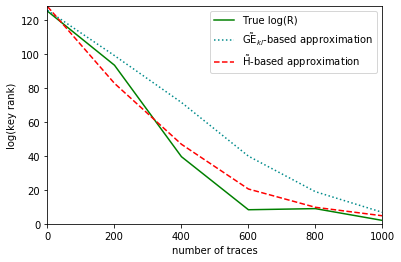

In [3]:
plt.plot(x,rank, label='True log(R)', color = 'green', linestyle='-')
plt.plot(x,ge, label ='$\~\mathrm{GE}_{kl}$-based approximation', color= 'darkcyan', linestyle=':')
plt.plot(x,e, label='$\~\mathrm{H}$-based approximation', color='r', linestyle='--')

plt.xlim(0,1000)
plt.ylim(0,128)

plt.xlabel('number of traces')
plt.ylabel('log(key rank)')
plt.legend(loc='best')
plt.show()

In [5]:
x = np.arange(0,1001,200)+1

rank = np.zeros(len(x))

d_r_mge = np.zeros(len(x))
d_r_ent = np.zeros(len(x))

max_d_r_mge = np.zeros(len(x))
min_d_r_mge = np.zeros(len(x))

max_d_r_ent = np.zeros(len(x))
min_d_r_ent = np.zeros(len(x))

var_e = np.zeros(len(x))
var_ge = np.zeros(len(x))

N = 10

for n in range(len(x)):
    print(n, ' out of ', len(x)-1)
    
    ve = np.zeros(N)
    vge = np.zeros(N)
    
    for sim in range(N):
        K = [rand.randint(0,255) for i in range(16)]
        
        correct_key_pdf , pdf_table = key(K,10, x[n], 16)
        RE = RankEstimation(pdf_table, correct_key_pdf, 0.05)
        r, rr, h, c, bs,i = RE.rank_estimation(True)
        
        c,h = normalize(c,h)
        
        ge = guessing_entropy(c,h)
        e = entropy(c,h)
        
        ve[sim] = abs(r - e)
        vge[sim] = abs(r - ge)
        
        rank[n] += r
        
        d_r_mge[n] += abs(r - ge)
        d_r_ent[n] += abs(r - e)
        
        max_d_r_mge[n] = max( max_d_r_mge[n], abs(r - ge))
        min_d_r_mge[n] = min( min_d_r_mge[n], abs(r - ge))

        max_d_r_ent[n] = max( max_d_r_ent[n], abs(r - e))
        min_d_r_ent[n] = min( min_d_r_ent[n], abs(r - e))
        
    var_e[n] = np.var(ve)
    var_ge[n] = np.var(vge)
    
rank = rank/N
d_r_mge = d_r_mge/N
d_r_ent = d_r_ent/N

0  out of  5
1  out of  5
2  out of  5
3  out of  5
4  out of  5
5  out of  5


C:\Users\nxf40085\Desktop\ALL\0xps_key_rank\RankEst.py:114: RuntimeWarning: divide by zero encountered in log2
  range_of_rank=[np.log2(lower_rank),np.log2(higher_rank)]


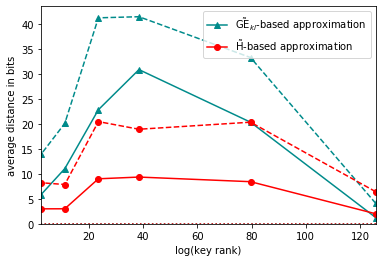

In [7]:
plt.plot(rank,d_r_mge, label='$\~\mathrm{GE}_{kl}$-based approximation', color='darkcyan', marker = '^')
plt.plot(rank,d_r_ent, label='$\~\mathrm{H}$-based approximation', color='r', marker = 'o')

plt.plot(rank,max_d_r_mge, marker = '^', linestyle ='--', color='darkcyan')
plt.plot(rank,min_d_r_mge, color='darkcyan', linestyle =':')

plt.plot(rank,max_d_r_ent, marker = 'o', linestyle ='--', color='r')
plt.plot(rank,min_d_r_ent, color='r', linestyle =':')

plt.ylim(0)
plt.xlim(min(rank),max(rank))
plt.xlabel('log(key rank)')
plt.ylabel('average distance in bits')

plt.legend(loc='best')
plt.show()